Script that takes nr data files, take signal in our direction, taper the start, propagate to the detectors, add noise, inject into detectors, plot.

First some imports

In [61]:
import bilby 
from bilby.core.prior import Uniform
from bilby.gw.utils import asd_from_freq_series

import numpy as np
import matplotlib
matplotlib.use("Qt5Agg") 
import matplotlib.pyplot as plt
%matplotlib widget
import h5py
import lalsimulation as lalsim
import lal
import os

from scipy.interpolate import UnivariateSpline
from scipy.optimize import root_scalar


Define some helpers:

In [62]:
#some inverse fourier transform helper 
def infft(frequency_domain_strain, sampling_frequency, length=None):
    """ Inverse FFT for use in conjunction with nfft.

    Parameters
    ----------
    frequency_domain_strain: array_like
        Single-sided, normalised FFT of the time-domain strain data (in units
        of strain / Hz).
    sampling_frequency: int, float
        Sampling frequency of the data.
    length: float
        length of the transformed axis of the output.
    """

    time_domain_strain_norm = np.fft.irfft(frequency_domain_strain, n=length)
    time_domain_strain = time_domain_strain_norm * sampling_frequency
    return time_domain_strain

Some bibly overhead

In [63]:
# Specify the output directory and the name of the simulation.
# bilby setup stuff
outdir = "outdir"
label = "phenomXP"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

Set parameters from NR injection waveform

In [64]:
# Set the binary parameters of the NR inejection waveform
# this is the angle and distance to the source
inclination = 0.78 
luminosity_distance = 250.
distance = luminosity_distance * lal.PC_SI * 1.0e6
phiRef = 0.0

# our relevant file path - create separate folder system
# filepath = 'chombo/GRChombo_BBSsol02_A147A147q100d12p000_Res40.h5'
filepath = 'chombo/GRChombo_BBSsol02_A17A17q100d17p000_Res40.h5' #DO THIS ONE NEXT
# pick parameters to mimic 25 event (inc,sky pos (?), total mass) (corresponding sky location (α = 2.333, δ = 0.190))
#  time tpeak = 1420878141.235932 s at geocenter
#filepath = 'grav_wave_boson_star_testing_gr/GRChombo_BBSsol02_A147A147q100d12p000_Res40.h5'
f = h5py.File(filepath, 'r')

Set up dictionary to store parameters. Populate it

In [65]:
# setting up dict to feed parameters into waveforms
params = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertNumRelData(params, filepath)

# Metadata parameters masses
mtotal = 71.5 # in solar masses. set total mass scale - sim only has relative (set to detector total mass from table 1)
# extract masses and convert to different units
m1 = f.attrs['mass1'] #code units
m2 = f.attrs['mass2']

mass_1 = m1 * mtotal / (m1 + m2) #solar masses
mass_2 = m2 * mtotal / (m1 + m2)

# Choose extrinsic parameters

m1SI = mass_1 * lal.MSUN_SI #in kg
m2SI = mass_2 * lal.MSUN_SI

spins = lalsim.SimInspiralNRWaveformGetSpinsFromHDF5File(0., mtotal, filepath)
s1x, s1y, s1z = spins[0], spins[1], spins[2]
s2x, s2y, s2z = spins[3], spins[4], spins[5]

# Set sampling frequency of the data segment that we're going to inject the signal into
# just be aware of aliasing issues if too low
sampling_frequency = 4096.0  # Hz
deltaT = 1.0/sampling_frequency #cadence

# we need to set the lowest trustable frequency - set as lowest simulated frequency, scaled by the chosen mass
#CHANGE THIS AFTER DOING THE TAPERING
f_lower = f.attrs['f_lower_at_1MSUN']/mtotal  # this choice generates the whole NR waveforms from the beginning
fRef = 0   #beginning of the waveform
fStart = f_lower


In [66]:
f.close()

Use `lalsim` to generate the waveform polarisations for the injection.

In [67]:
params = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertNumRelData(params, filepath)

approx = lalsim.NR_hdf5

inject_l_modes=[2]
ModeArray = lalsim.SimInspiralCreateModeArray()
for mode in inject_l_modes:
    lalsim.SimInspiralModeArrayActivateAllModesAtL(ModeArray, mode)

lalsim.SimInspiralWaveformParamsInsertModeArray(params, ModeArray)

# these are the steps we need to redo later, with a new inclination angle
h_p, h_c = lalsim.SimInspiralChooseTDWaveform(m1SI, m2SI, s1x, s1y, s1z,
                s2x, s2y, s2z, distance, inclination, phiRef, np.pi/2., 0.0, 0.0, 
                deltaT, fStart, fRef, params, approx)

times = np.arange(len(h_p.data.data))*h_p.deltaT

We plot the results

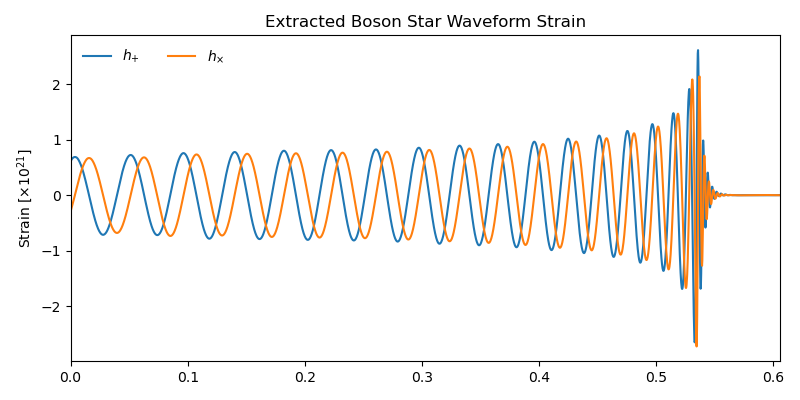

In [68]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(8, 4))

# plot initial signal
ax.plot(times, 1.0e21*h_p.data.data, ls='-', label=r'$h_{+}$')
ax.plot(times, 1.0e21*h_c.data.data, ls='-', label=r'$h_{\times}$')
ax.set_ylabel(r'Strain [$\times 10^{21}$]')
ax.set_xlim(times[0], times[-1])
ax.legend(loc='upper left', frameon=False, ncols=2)
plt.title('Extracted Boson Star Waveform Strain')

plt.tight_layout()
plt.show()

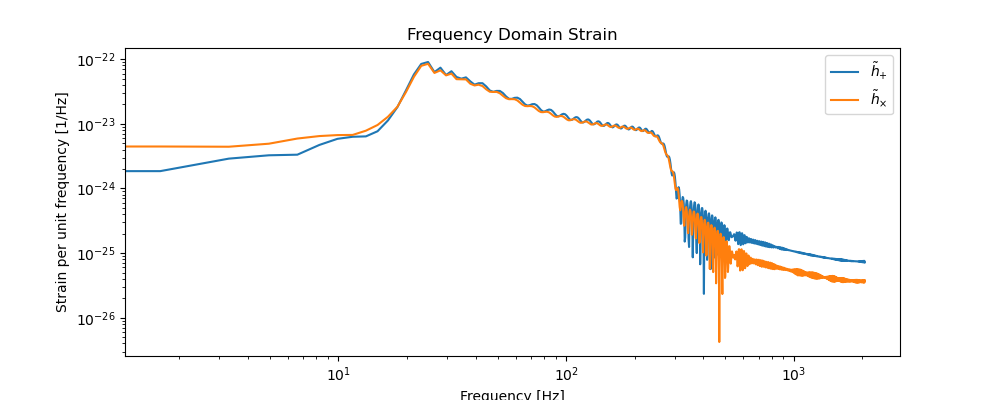

In [69]:
# plot frequency domain strain
padded_fr_plus = np.fft.rfft(h_p.data.data) / sampling_frequency
padded_fr_cross = np.fft.rfft(h_c.data.data) / sampling_frequency
freqs = np.fft.rfftfreq(len(h_p.data.data), d=1.0/sampling_frequency)

plt.figure(figsize=(10, 4))
plt.loglog(freqs, np.abs(padded_fr_plus), label='$\~h_{+}$')
plt.loglog(freqs, np.abs(padded_fr_cross), label='$\~h_{\\times}$')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain per unit frequency [1/Hz]')
plt.title('Frequency Domain Strain')
plt.legend()
plt.show()

We use bilby:

In [70]:
def create_nr_injection(times_array, hp_array, hc_array):
    """
    Factory function that creates a custom NR injection function
    with specific time series data.
    """
    def nr_injection(time):
            
        hp = np.interp(time, times_array, hp_array)
        hc = np.interp(time, times_array, hc_array)
        return {"plus": hp, "cross": hc}
    
    return nr_injection

14:53 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.60595703125, sampling_frequency=4096.0, start_time=0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})


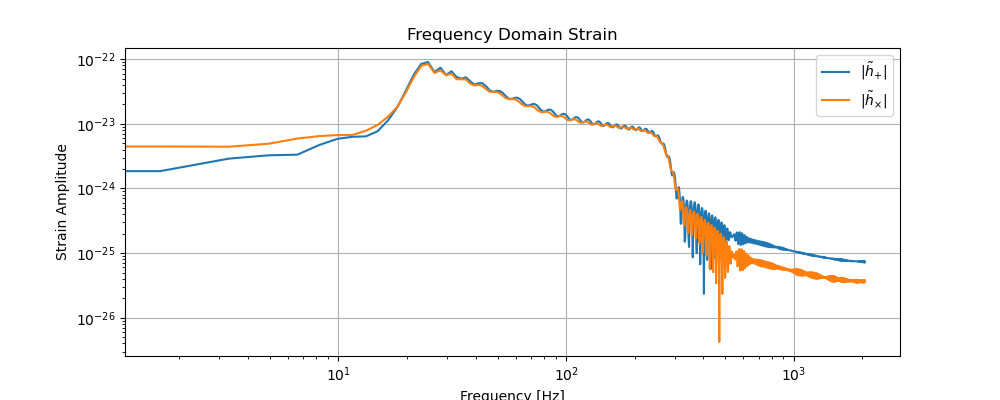

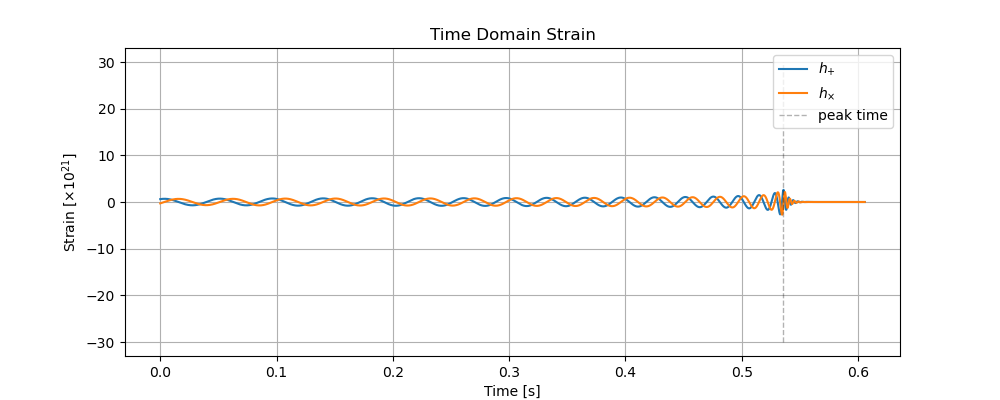

In [71]:
# propagate and inject each tapered signal
# create dict to store the data
original_hp = np.copy(h_p.data.data)
original_hc = np.copy(h_c.data.data)

amplitude = np.sqrt(h_p.data.data**2 + h_c.data.data**2)
peak_id = np.argmax(amplitude)
peak = times[peak_id]

hplus = h_p.data.data[peak_id]
hcross = h_c.data.data[peak_id]
phase_merger = np.arctan2(-hcross,hplus) + np.pi


#duration = times_padded[-1]
start_time = times[0]
duration = len(times) / sampling_frequency

np.random.seed(88170235)
injection_parameters = dict(
    mass_1=mass_1,
    mass_2=mass_2,
    a_1=0.0,
    a_2=0.0,
    tilt_1=0.0,
    tilt_2=0.0,
    phi_12=0.0,
    phi_jl=0.0,
    luminosity_distance=luminosity_distance,
    theta_jn=inclination,
    psi=np.pi/2,
    phase=phase_merger,
    geocent_time=0,
    ra=1.375,
    dec=-1.2108
)

nr_injection_wf = create_nr_injection(times, h_p.data.data, h_c.data.data)

# propagate to interferometers
waveform = bilby.gw.waveform_generator.WaveformGenerator(duration=duration, sampling_frequency=sampling_frequency,
        time_domain_source_model=nr_injection_wf, start_time=0);

# get time and frequency domain strains and arrays
time_domain = waveform.time_domain_strain(parameters=injection_parameters);
time_array = waveform.time_array

fr_domain = waveform.frequency_domain_strain(parameters=injection_parameters);
fr_array = waveform.frequency_array

# these still look good, no weird shifts


# plot frequency domain strain
plt.figure(figsize=(10, 4))
plt.loglog(fr_array, np.abs(fr_domain['plus']), label='$|\\tilde{h}_{+}|$')
plt.loglog(fr_array, np.abs(fr_domain['cross']), label='$|\\tilde{h}_{\\times}|$')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain Amplitude')
plt.title(f'Frequency Domain Strain')
plt.legend()
plt.grid()
plt.show()
#plot time domain strain
plt.figure(figsize=(10, 4))
plt.plot(time_array, 1.0e21*time_domain['plus'], label='$h_{+}$')
plt.plot(time_array, 1.0e21*time_domain['cross'], label='$h_{\\times}$')
plt.vlines(peak, -30, 30, color='k', ls='--', alpha=0.3, lw=1, label='peak time')
plt.xlabel('Time [s]')
plt.ylabel('Strain [$\\times 10^{21}$]')
plt.title(f'Time Domain Strain')
plt.legend()
plt.grid()
plt.show()
#can try to suppress high freqs here, see if that fixes post bilby signals (band pass filter)

In [72]:
# create ifos and inject signal and noise
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1']);
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=start_time);
ifos.inject_signal(waveform_generator=waveform,
                parameters=injection_parameters, raise_error=False);

14:53 bilby INFO    : Injected signal in H1:
14:53 bilby INFO    :   optimal SNR = 79.77
14:53 bilby INFO    :   matched filter SNR = 79.58-0.71j
14:53 bilby INFO    :   mass_1 = 35.75
14:53 bilby INFO    :   mass_2 = 35.75
14:53 bilby INFO    :   a_1 = 0.0
14:53 bilby INFO    :   a_2 = 0.0
14:53 bilby INFO    :   tilt_1 = 0.0
14:53 bilby INFO    :   tilt_2 = 0.0
14:53 bilby INFO    :   phi_12 = 0.0
14:53 bilby INFO    :   phi_jl = 0.0
14:53 bilby INFO    :   luminosity_distance = 250.0
14:53 bilby INFO    :   theta_jn = 0.78
14:53 bilby INFO    :   psi = 1.5707963267948966
14:53 bilby INFO    :   phase = 4.052962732862897
14:53 bilby INFO    :   geocent_time = 0
14:53 bilby INFO    :   ra = 1.375
14:53 bilby INFO    :   dec = -1.2108
14:53 bilby INFO    : Injected signal in L1:
14:53 bilby INFO    :   optimal SNR = 59.57
14:53 bilby INFO    :   matched filter SNR = 58.03+1.57j
14:53 bilby INFO    :   mass_1 = 35.75
14:53 bilby INFO    :   mass_2 = 35.75
14:53 bilby INFO    :   a_1 = 0

In [73]:
#locate the merger (peak amplitude) in the ifo data
ifo = ifos[0]  # pick one interferometer to plot
times_ifo = ifo.time_array
strain = ifo.time_domain_strain
amplitude = np.sqrt(strain**2)
peak_id_ifo = np.argmax(amplitude)
peak_time_ifo = times_ifo[peak_id_ifo]

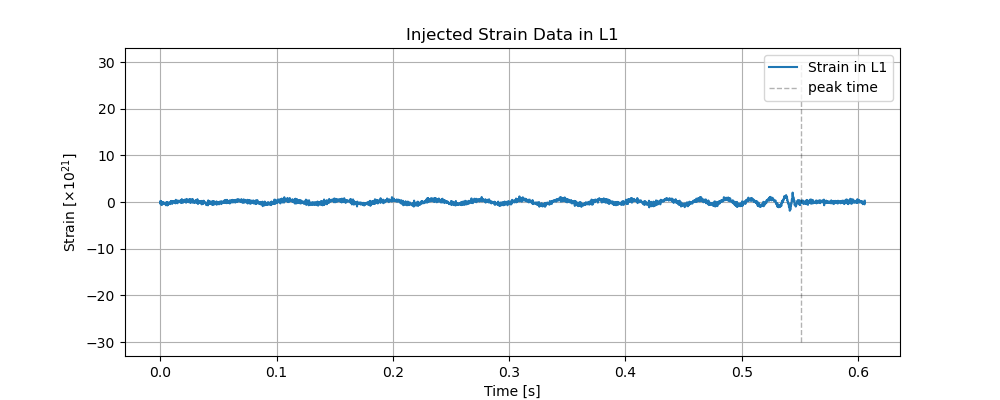

In [74]:
# try some plotting of the ifo data

ifo = ifos[1]  # pick one interferometer to plot
times_ifo = ifo.time_array
strain = ifo.time_domain_strain
plt.figure(figsize=(10, 4))
plt.plot(times_ifo, 1.0e21*strain, label=f'Strain in {ifo.name}')
plt.vlines(peak_time_ifo, -30, 30, color='k', ls='--', alpha=0.3, lw=1, label='peak time')
plt.xlabel('Time [s]')
plt.ylabel('Strain [$\\times 10^{21}$]')
plt.title(f'Injected Strain Data in {ifo.name}')
plt.legend()
plt.grid()
plt.show()

Now we want to generate the relevant datasets to at least get a new strain timeseries. Need to adapt this to work for each fcn

In [75]:
# Generate some intermmediate plot files
# these are different versions of datafiles, prob wont need most of them
start_time = 0
end_time = duration

for ifo in ifos:
    time_idxs = (
                (ifo.time_array >= start_time) &
                (ifo.time_array <= end_time)
                ) #returns a boolean array of interferometer time

    frequency_idxs = np.where(ifo.frequency_mask)[0]
    frequency_idxs = frequency_idxs[::max(1, len(frequency_idxs) // 4000)]
    plot_times = ifo.time_array[time_idxs]
    plot_frequencies = ifo.frequency_array[frequency_idxs]

    frequency_window_factor = (
                np.sum(ifo.frequency_mask)
                / len(ifo.frequency_mask)
            ) # create a window factor using a masking array for limiting the frequency band 
    hf_d = asd_from_freq_series(
                ifo.frequency_domain_strain[frequency_idxs],
                1 / ifo.strain_data.duration)
    ht_d = np.fft.irfft(ifo.whitened_frequency_domain_strain
                            * np.sqrt(np.sum(ifo.frequency_mask))
                            / frequency_window_factor, n=len(time_idxs)
                        )[time_idxs]
    
    # Save data stream here
    np.savetxt("outdir/"+ifo.name+"_time_data_stream.dat", np.column_stack([plot_times, ht_d]), delimiter='   ')

    np.savetxt("outdir/"+ifo.name+"_frequency_data_stream.dat", np.column_stack([plot_frequencies, ifo.frequency_domain_strain[frequency_idxs]]), delimiter='   ')

    np.savetxt("outdir/"+ifo.name+"_frequency_asd_data_stream.dat", np.column_stack([plot_frequencies, hf_d]), delimiter='   ')

    hf_inj = waveform.frequency_domain_strain(injection_parameters)
    hf_inj_det = ifo.get_detector_response(hf_inj, injection_parameters)
    ht_inj_det = infft(hf_inj_det * np.sqrt(2. / ifo.sampling_frequency) /
                            ifo.amplitude_spectral_density_array,
                            sampling_frequency, len(time_idxs))[time_idxs]
    
    # Try this (raw detector response without whitening):
    ht_inj_det_raw = infft(hf_inj_det, sampling_frequency, len(time_idxs))[time_idxs]

    # Save injections to file 
    np.savetxt("outdir/"+ifo.name+"_time_injection_waveform.dat", np.column_stack([plot_times, ht_inj_det]), delimiter='   ')

    np.savetxt("outdir/"+ifo.name+"_frequency_injection_waveform.dat", np.column_stack([plot_frequencies, hf_inj_det[frequency_idxs]]), delimiter='   ')

    np.savetxt("outdir/"+ifo.name+"_frequency_asd_injection_waveform.dat", np.column_stack([plot_frequencies, asd_from_freq_series(hf_inj_det[frequency_idxs], 1 / ifo.strain_data.duration)]), delimiter='   ')

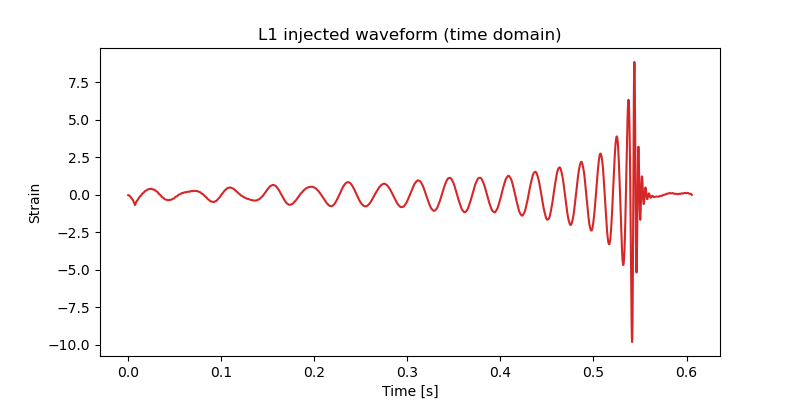

/home/selmavangstein/miniconda3/envs/ringdown/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/selmavangstein/miniconda3/envs/ringdown/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_26819/1154181009.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[4].legend()


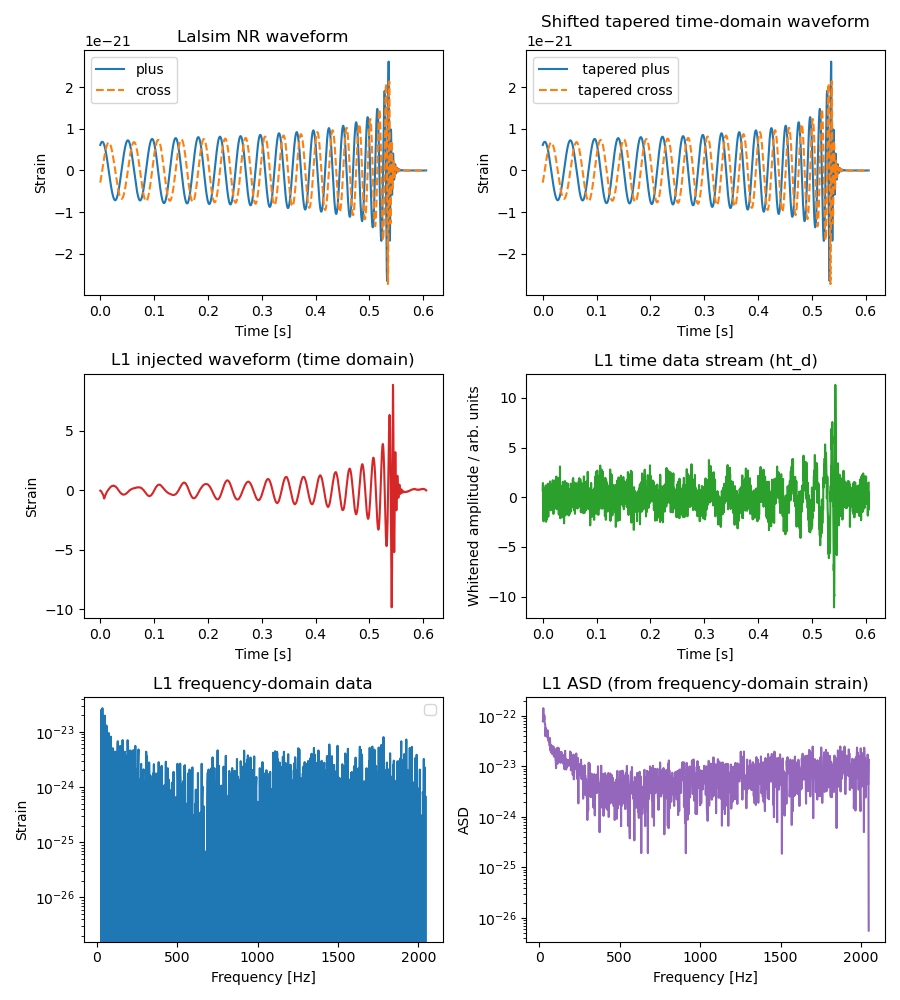

/tmp/ipykernel_26819/1154181009.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


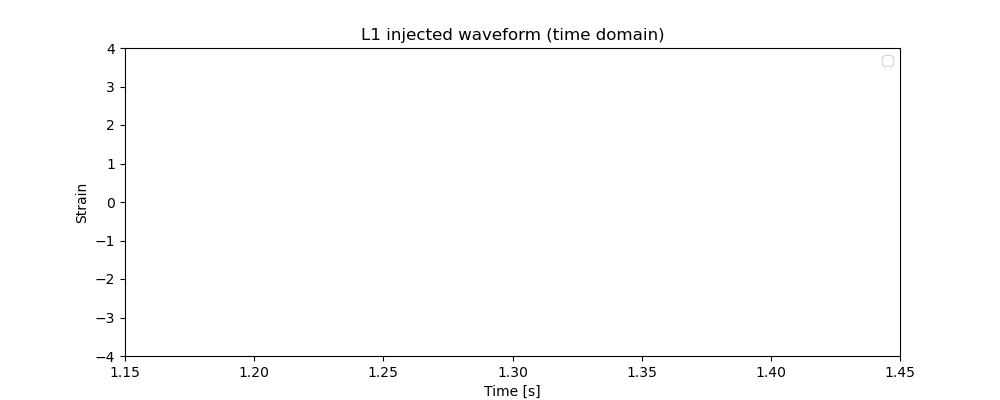

In [76]:
plt.figure(figsize=(8, 4))
plt.plot(plot_times, ht_inj_det, color="C3")
plt.title(f"{ifo.name} injected waveform (time domain)")
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.show()


fig, axes = plt.subplots(3, 2, figsize=(9, 10))
ax = axes.flatten()
ifo = ifos[1]  # Just plot for the first interferometer

# 2) Lalsim NR waveform (plus & cross)
ax[0].plot(times, original_hp, label="plus")
ax[0].plot(times, original_hc, ls="--", label="cross")
ax[0].set_title("Lalsim NR waveform")
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Strain")
ax[0].legend()

# 2) Tapered time-domain waveform (plus & cross). Output from Bilby waveform generator
ax[1].plot(time_array, time_domain["plus"], label=" tapered plus")
ax[1].plot(time_array, time_domain["cross"], ls="--", label="tapered cross")
ax[1].set_title("Shifted tapered time-domain waveform")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Strain")
ax[1].legend()

# 3) Detector injected time-series (ht_inj_det)
ax[2].plot(plot_times, ht_inj_det, color="C3")
ax[2].set_title(f"{ifo.name} injected waveform (time domain)")
ax[2].set_xlabel("Time [s]")
ax[2].set_ylabel("Strain")

# 4) Detector time-series (ht_d)
ax[3].plot(plot_times, ht_d, color="C2")
ax[3].set_title(f"{ifo.name} time data stream (ht_d)")
ax[3].set_xlabel("Time [s]")
ax[3].set_ylabel("Whitened amplitude / arb. units")

# 5) Detector frequency-domain data
ax[4].plot(plot_frequencies, ifo.frequency_domain_strain[frequency_idxs])
ax[4].set_yscale("log")
ax[4].set_title(f"{ifo.name} frequency-domain data")
ax[4].set_xlabel("Frequency [Hz]")
ax[4].set_ylabel("Strain")
ax[4].legend()

# 6) ASD from interferometer frequency-domain strain (subset used for plotting)
ax[5].plot(plot_frequencies, hf_d, color="C4")
ax[5].set_yscale("log")
ax[5].set_title(f"{ifo.name} ASD (from frequency-domain strain)")
ax[5].set_xlabel("Frequency [Hz]")
ax[5].set_ylabel("ASD")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(plot_times, ht_inj_det, color="C3")
plt.title(f"{ifo.name} injected waveform (time domain)")
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.xlim(1.15,1.45)
plt.ylim(-4,4)
plt.legend()
plt.show()